# Lab | Text Generation from Shakespeare's Sonnet

This notebook explores the fascinating domain of text generation using a deep learning model trained on Shakespeare's sonnets.

The objective is to create a neural network capable of generating text sequences that mimic the style and language of Shakespeare.

By utilizing a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers, this project aims to demonstrate how a model can learn and replicate the complex patterns of early modern English.

The dataset used consists of Shakespeare's sonnets, which are preprocessed and tokenized to serve as input for the model.

Throughout this notebook, you will see the steps taken to prepare the data, build and train the model, and evaluate its performance in generating text.

This lab provides a hands-on approach to understanding the intricacies of natural language processing (NLP) and the potential of machine learning in creative text generation.

Let's import necessary libraries

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku
import numpy as np 

Let's get the data!

In [6]:
import requests
url = 'https://raw.githubusercontent.com/martin-gorner/tensorflow-rnn-shakespeare/master/shakespeare/sonnets.txt'
resp = requests.get(url)
with open('sonnets.txt', 'wb') as f:
    f.write(resp.content)

data = open('sonnets.txt').read()

corpus = data.lower().split("\n")

Step 1: Initialise a tokenizer and fit it on the corpus variable using .fit_on_texts

In [7]:
#  Initialize a Tokenizer and fit it on the corpus
tokenizer = Tokenizer(num_words=5000)  # Limit to the 5000 most common words
tokenizer.fit_on_texts(corpus)

# print the number of unique tokens
print("Unique tokens:", len(tokenizer.word_index))

Unique tokens: 3374


Step 2: Calculate the Vocabulary Size

Let's figure out how many unique words are in your corpus. This will be the size of your vocabulary.

Calculate the length of tokenizer.word_index, add 1 to it and store it in a variable called total_words.

In [8]:
#  Calculate the Vocabulary Size
total_words = len(tokenizer.word_index) + 1
print("Total vocabulary size:", total_words)

Total vocabulary size: 3375


Create an empty list called input_sequences.

For each sentence in your corpus, convert the text into a sequence of integers using the tokenizer.
Then, generate n-gram sequences from these tokens.

Store the result in the list input_sequences.

In [9]:
# Initialize an empty list to store n-gram sequences
input_sequences = []

# Loop through each sentence in the corpus
for sentence in corpus:
    # Convert the sentence into a list of numerical tokens
    token_list = tokenizer.texts_to_sequences([sentence])[0]

    # Loop through the token list to create n-gram sequences
    for i in range(1, len(token_list)):
        # Generate an n-gram sequence by slicing from the start up to the (i+1)th token
        n_gram_sequence = token_list[:i+1]

        # Append the generated n-gram sequence to the list of input sequences
        input_sequences.append(n_gram_sequence)

Calculate the length of the longest sequence in input_sequences. Assign the result to a variable called max_sequence_len.

Now pad the sequences using pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre').
Convert it to a numpy array and assign the result back to our variable called input_sequences.

In [10]:
# Step 1: Find the longest sequence length
max_sequence_len = max(len(seq) for seq in input_sequences)

# Step 2: Pad all sequences to ensure uniform length
input_sequences = pad_sequences(input_sequences,
                                maxlen=max_sequence_len,
                                padding='pre')

# Step 3: Convert the padded sequences into a NumPy array
input_sequences = np.array(input_sequences)

Prepare Predictors and Labels

Split the sequences into two parts:

- Predictors: All elements from input_sequences except the last one.
- Labels: The last element of each sequence in input_sequences.

In [11]:
# Step 1: Split sequences into predictors and labels
X = input_sequences[:, :-1]  # All elements except the last one
y = input_sequences[:, -1]   # Only the last element



One-Hot Encode the Labels :

Convert the labels (which are integers) into one-hot encoded vectors.

Ensure the length of these vectors matches the total number of unique words in your vocabulary.

Use ku.to_categorical() on labels with num_classes = total_words

Assign the result back to our variable labels.

In [12]:
# Step 2: Convert labels (y) into categorical format
y = ku.to_categorical(y, num_classes=total_words)  # One-hot encoding

# Initialize the Model

Start by creating a Sequential model.

Add Layers to the Model:

Embedding Layer: The first layer is an embedding layer. It converts word indices into dense vectors of fixed size (100 in this case). Set the input length to the maximum sequence length minus one, which corresponds to the number of previous words the model will consider when predicting the next word.

Bidirectional LSTM Layer: Add a Bidirectional LSTM layer with 150 units. This layer allows the model to learn context from both directions (past and future) in the sequence. return_sequences=True

Dropout Layer: Add a dropout layer with a rate of 0.2 to prevent overfitting by randomly setting 20% of the input units to 0 during training.

LSTM Layer: Add a second LSTM layer with 100 units. This layer processes the sequence and passes its output to the next layer.

Dense Layer (Intermediate): Add a dense layer with half the total number of words as units, using ReLU activation. A regularization term (L2) is added to prevent overfitting.

Dense Layer (Output): The final dense layer has as many units as there are words in the vocabulary, with a softmax activation function to output a probability distribution over all words.

In [13]:
model = Sequential([

    # Embedding Layer
    Embedding(input_dim=total_words,  # Vocabulary size
              output_dim=100,         # Each word is mapped to a 100-dimensional vector
              input_length=max_sequence_len - 1),  # Number of words used as input
    # LSTM Layer
    LSTM(150, return_sequences=True),  # LSTM with 150 units, return sequences for stacking

    #Dropout Layer (Prevents Overfitting)
    Dropout(0.2),

    # Another LSTM Layer (optional but improves performance)
    LSTM(100),  # Second LSTM layer with 100 units

    # Intermediate Dense Layer with L2 Regularization
    Dense(total_words // 2, activation="relu",  # Uses ReLU for better feature learning
          kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization (reduces overfitting)

    # Final Dense Output Layer
    Dense(total_words, activation="softmax")  # Outputs probability distribution over all words
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# Compile the Model:

Compile the model using categorical crossentropy as the loss function, the Adam optimizer for efficient training, and accuracy as the metric to evaluate during training.

In [14]:
# Compile the model
model.compile(loss='categorical_crossentropy',  # Loss function for multi-class classification
              optimizer=Adam(learning_rate=0.001),  # Adam optimizer with learning rate 0.01
              metrics=['accuracy'])  # Accuracy as evaluation metric

# Print Model Summary:

Use model.summary() to print a summary of the model, which shows the layers, their output shapes, and the number of parameters.

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Now train the model for 50 epochs and assign it to a variable called history.

Training the model with 50 epochs should get you around 40% accuracy.

You can train the model for as many epochs as you like depending on the time and computing constraints you are facing. Ideally train it for a larger amount of epochs than 50.

That way you will get better text generation at the end.

However, dont waste your time.

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='loss',  # Monitor loss to reduce LR when needed
                              factor=0.5,      # Reduce LR by 50% when triggered
                              patience=1,      # Wait 5 epochs before reducing
                              min_lr=0.00001)   # Minimum learning rate allowed


In [25]:
# Train the model for 55 epochs
history = model.fit(X, y,
                    epochs=55,
                    batch_size=32,
                    verbose=1,
                    callbacks=[reduce_lr] )

Epoch 1/55
484/484 ━━━━━━━━━━━━━━━━━━━━ 66s 135ms/step - accuracy: 0.0229 - loss: 6.5079 - learning_rate: 0.0010
Epoch 2/55
484/484 ━━━━━━━━━━━━━━━━━━━━ 63s 131ms/step - accuracy: 0.0193 - loss: 6.4545 - learning_rate: 0.0010
Epoch 3/55
484/484 ━━━━━━━━━━━━━━━━━━━━ 83s 134ms/step - accuracy: 0.0246 - loss: 6.3461 - learning_rate: 0.0010
Epoch 4/55
484/484 ━━━━━━━━━━━━━━━━━━━━ 81s 131ms/step - accuracy: 0.0299 - loss: 6.2731 - learning_rate: 0.0010
Epoch 5/55
484/484 ━━━━━━━━━━━━━━━━━━━━ 62s 129ms/step - accuracy: 0.0367 - loss: 6.1609 - learning_rate: 0.0010
Epoch 6/55
484/484 ━━━━━━━━━━━━━━━━━━━━ 82s 129ms/step - accuracy: 0.0396 - loss: 6.0796 - learning_rate: 0.0010
Epoch 7/55
484/484 ━━━━━━━━━━━━━━━━━━━━ 62s 129ms/step - accuracy: 0.0415 - loss: 5.9938 - learning_rate: 0.0010
Epoch 8/55
484/484 ━━━━━━━━━━━━━━━━━━━━ 82s 130ms/step - accuracy: 0.0419 - loss: 5.9479 - learning_rate: 0.0010
Epoch 9/55
484/484 ━━━━━━━━━━━━━━━━━━━━ 80s 127ms/step - accuracy: 0.0437 - loss: 5.8859 - learn

# Use plt from matplotlib to plot the training accuracy over epochs and the loss over epochs

First you will have to get the accuracy and loss data over epochs, you can do this by using methods on your model.

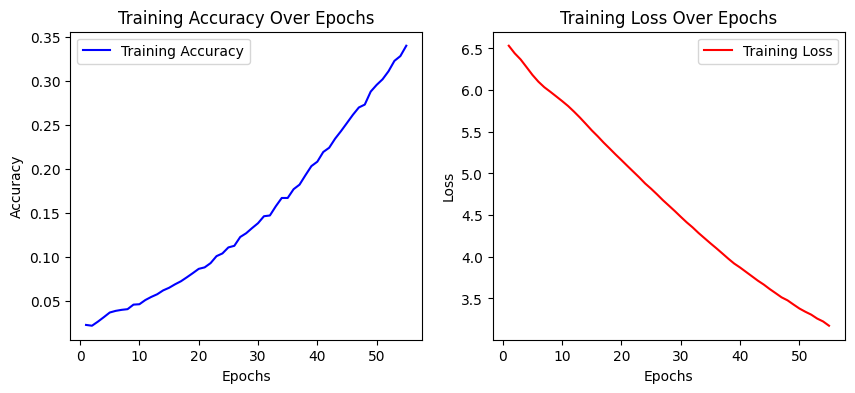

In [26]:
# Extract accuracy and loss from training history
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(1, len(acc) + 1)  # Generate epoch numbers

import matplotlib.pyplot as plt

# Plot Accuracy Over Epochs
plt.figure(figsize=(10, 4))  # Set figure size

plt.subplot(1, 2, 1)  # First subplot for accuracy
plt.plot(epochs, acc, 'b', label='Training Accuracy')  # Blue line
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()

# Plot Loss Over Epochs
plt.subplot(1, 2, 2)  # Second subplot for loss
plt.plot(epochs, loss, 'r', label='Training Loss')  # Red line
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Show the plots
#plt.tight_layout()  # Adjust layout for better spacing
plt.show()

# Generate text with the model based on a seed text

Now you will create two variables :

- seed_text = 'Write the text you want the model to use as a starting point to generate the next words'
- next_words = number_of_words_you_want_the_model_to_generate

Please change number_of_words_you_want_the_model_to_generate by an actual integer.

In [34]:
seed_text = "once apon a time "  # Input seed text
next_words = 50  # Number of words to generate

Now create a loop that runs based on the next_words variable and generates new text based on your seed_text input string. Print the full text with the generated text at the end.

This time you dont get detailed instructions.

Have fun!

In [30]:
def generate_text(model, tokenizer, seed_text, next_words, max_sequence_len):
    """
    Generates text using a trained LSTM model.

    Arguments:
    - model: Trained LSTM model
    - tokenizer: Tokenizer used during training
    - seed_text: Initial input text
    - next_words: Number of words to generate
    - max_sequence_len: Maximum sequence length used in training

    Returns:
    - Generated text as a string
    """

    for _ in range(next_words):
        # Convert current text to tokens
        token_list = tokenizer.texts_to_sequences([seed_text])[0]

        # Pad sequence to match model's expected input shape
        token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')

        # Predict the next word
        predicted_probs = model.predict(token_list, verbose=0)
        predicted_index = np.argmax(predicted_probs, axis=-1)[0]  # Get most probable word index

        # Convert index to word
        output_word = None
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break  # Stop searching when word is found

        # If no valid word is found, stop generation
        if output_word is None:
            break

        # Append predicted word to seed text
        seed_text += " " + output_word

    return seed_text  # Return the final generated text

In [35]:
# Generate text
generated_text = generate_text(model, tokenizer, seed_text, next_words, max_sequence_len)
# Print the generated text
print("\nGenerated Text:\n")
print(generated_text)


Generated Text:

once apon a time  holds thou be forget my cloak rhyme 'will' grow'st taken right days kind ' ' allay'd o'er foil'd where now truth twain ' alive mine ' ' thereby love ' uphold yet boast ' ' a dancing ' yield me still another doom of fine ' 'will' night boundless '


Experiment with at least 3 different seed_text strings and see what happens!

In [36]:
# Define seed text and number of words to generate
seed_text = "the dark knight"
next_words = 30
# Generate text
generated_text = generate_text(model, tokenizer, seed_text, next_words, max_sequence_len)
# Print the generated text
print("\nGenerated Text:\n")
print(generated_text)


Generated Text:

the dark knight of spirits are o'er out a night leaves ' ' ' razed adulterate ' lie ' to visage sing to thee so short mine eyes more love ' loved all


In [37]:
# Define seed text and number of words to generate
seed_text = "the blue sky "
next_words = 35
# Generate text
generated_text = generate_text(model, tokenizer, seed_text, next_words, max_sequence_len)
# Print the generated text
print("\nGenerated Text:\n")
print(generated_text)


Generated Text:

the blue sky  of sway laugh'd and anon chaste treasure do ' ' ' ' physic we sea's seasons' 'amen' pluck thee now be sit brand dream taken rehearse more forsworn i go ' lie thus in me


In [38]:
# Define seed text and number of words to generate
seed_text = "fire and ash"
next_words = 30
# Generate text
generated_text = generate_text(model, tokenizer, seed_text, next_words, max_sequence_len)
# Print the generated text
print("\nGenerated Text:\n")
print(generated_text)


Generated Text:

fire and ash these touches night iniquity flatter'd be taken leaves ' move ' ' till not remote fair now brand mine eyes be writ not you ' ' poet's stol'n found me
